In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (Pima Indians Diabetes Dataset)
# You can download it from: https://www.kaggle.com/uciml/pima-indians-diabetes-database
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
               'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

In [7]:
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows of the dataset:")
print(data.head())

# Check for missing values (coded as 0 in this dataset)
# Replace 0s with NaN for relevant columns
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[zero_columns] = data[zero_columns].replace(0, np.nan)

# Fill missing values with mean (simple imputation)
data.fillna(data.mean(), inplace=True)

# Feature and target separation
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize all classifiers
classifiers = {
    "Classification Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "k-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Neural Network": MLPClassifier(random_state=42, max_iter=1000),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}

Dataset Shape: (768, 9)

First 5 rows of the dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [8]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for AUC

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }

# Evaluate all models
results = {}
for name, clf in classifiers.items():
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(clf, X_train, X_test, y_train, y_test)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print("\nPerformance Comparison:")
print(results_df)

# Cross-validation (10-fold as in the paper)
print("\nRunning 10-fold cross-validation for Logistic Regression (best model)...")
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_val_score(LogisticRegression(), X_scaled, y, cv=kfold, scoring='accuracy')
print(f"\nCross-validation Accuracy: {cv_results.mean():.4f} (±{cv_results.std():.4f})")



Evaluating Classification Tree...

Evaluating SVM...

Evaluating k-NN...

Evaluating Naive Bayes...

Evaluating Random Forest...

Evaluating Neural Network...

Evaluating AdaBoost...

Evaluating Logistic Regression...

Performance Comparison:
                     Accuracy  Precision    Recall  F1 Score       AUC
Classification Tree  0.720779   0.607143  0.618182  0.612613  0.697980
SVM                  0.753247   0.680851  0.581818  0.627451  0.810285
k-NN                 0.740260   0.615385  0.727273  0.666667  0.776492
Naive Bayes          0.746753   0.637931  0.672727  0.654867  0.832323
Random Forest        0.753247   0.654545  0.654545  0.654545  0.831221
Neural Network       0.727273   0.610169  0.654545  0.631579  0.798347
AdaBoost             0.753247   0.644068  0.690909  0.666667  0.804775
Logistic Regression  0.753247   0.666667  0.618182  0.641509  0.824242

Running 10-fold cross-validation for Logistic Regression (best model)...

Cross-validation Accuracy: 0.7695 (±0.0542

<Figure size 1200x800 with 0 Axes>

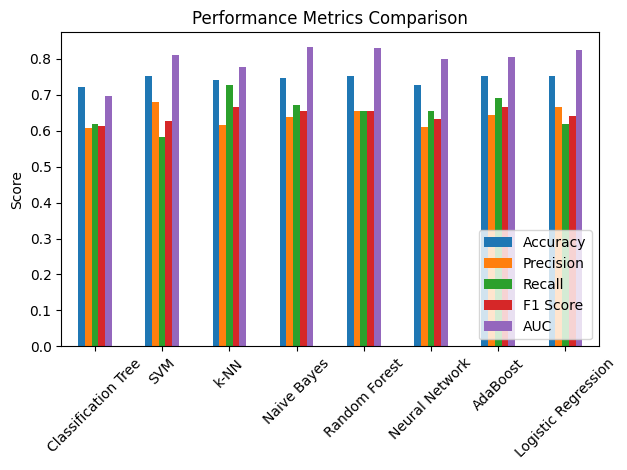

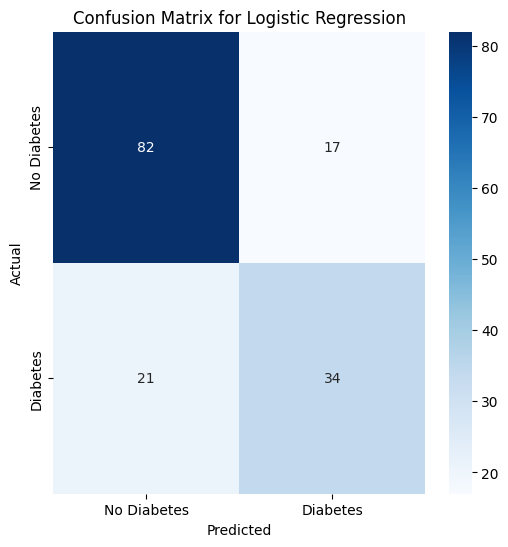

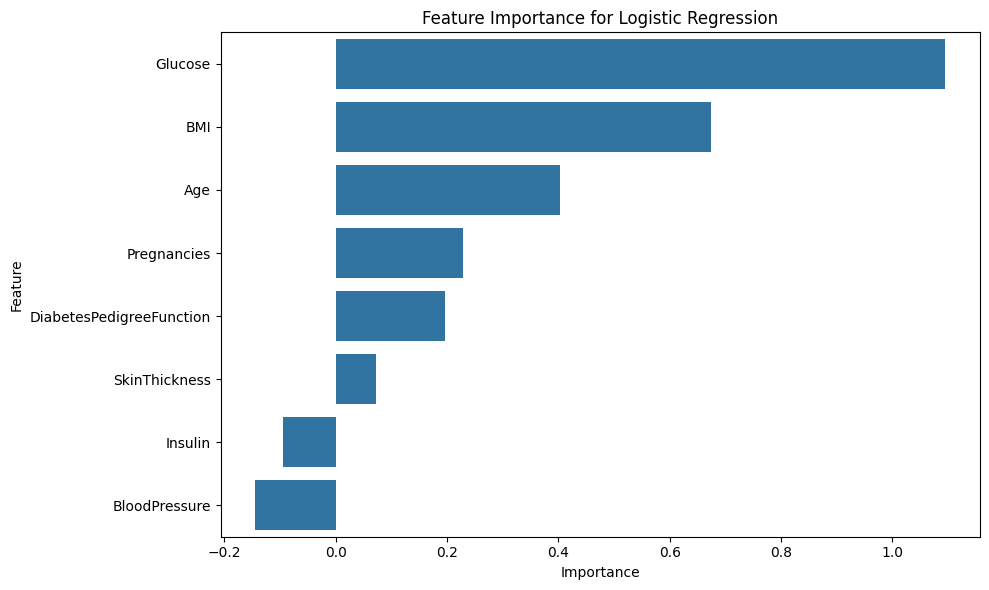

In [9]:
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', y=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
plt.title('Performance Metrics Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Confusion matrix for Logistic Regression (best model)
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix for Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature importance for Logistic Regression
if hasattr(lr, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': column_names[:-1],
        'Importance': lr.coef_[0]
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance for Logistic Regression')
    plt.tight_layout()
    plt.show()